# We love shrooms

In [7]:
import warnings
warnings.filterwarnings("ignore")

In [8]:
import kagglehub
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

In [9]:
# load the dataset
path = kagglehub.dataset_download("uciml/mushroom-classification")
mushroom = pd.read_csv(path + "/mushrooms.csv")
mushroom.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [59]:
print("--- Data Type Counts ---")
print(mushroom.dtypes.value_counts())
print("\n" + "="*40 + "\n")

categorical_cols = mushroom.select_dtypes(include=['object']).columns.tolist()
print(f"--- Categorical Attributes ({len(categorical_cols)}) ---")
print(*categorical_cols, sep='\n')
print("\n" + "="*40 + "\n")

numerical_cols = mushroom.select_dtypes(include=['float64', 'int64']).columns.tolist()
print(f"--- Numerical or Binary Attributes({len(numerical_cols)}) ---")
print(*numerical_cols, sep='\n')

--- Data Type Counts ---
object    23
Name: count, dtype: int64


--- Categorical Attributes (23) ---
class
cap-shape
cap-surface
cap-color
bruises
odor
gill-attachment
gill-spacing
gill-size
gill-color
stalk-shape
stalk-root
stalk-surface-above-ring
stalk-surface-below-ring
stalk-color-above-ring
stalk-color-below-ring
veil-type
veil-color
ring-number
ring-type
spore-print-color
population
habitat


--- Numerical or Binary Attributes(0) ---



In [34]:
# Model Development
X = mushroom.drop(columns=['class'])
y = mushroom['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

categorical_feats = X_train.select_dtypes(include=['object']).columns.tolist()
categorical_preprocessor = Pipeline(
    steps=[
        (
            "imputation_constant", # Impute missing categorical values with a constant string
            SimpleImputer(fill_value="missing", strategy="most_frequent"),
        ),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)

pipe = Pipeline(steps=[
    ('preprocessor', ColumnTransformer(
        transformers=[
            ('categorical', categorical_preprocessor, categorical_feats)
        ]),

     ),
    ('classifier', None)  # Placeholder for the model to be added later
])

# Define the parameter grids for different models
# Note: <step>__<parameter_name> is used to specify parameters for the classifier step in the pipeline
param_grid = [
    {
        'classifier': [LogisticRegression(random_state=42, max_iter=1000)],
        'classifier__C': [0.1, 1.0, 10],
        'classifier__solver': ['liblinear']
    },
    {
        'classifier': [RandomForestClassifier(random_state=42)],
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [5, 10, None]
    },
    {
        'classifier': [SVC(random_state=42, probability=True)],
        'classifier__C': [0.1, 1.0, 10],
        'classifier__gamma': ['scale', 'auto']
    },
    {
        'classifier': [KNeighborsClassifier()],
        'classifier__n_neighbors': [3, 5, 7],
        'classifier__weights': ['uniform', 'distance']
    },
    {
        'classifier': [DecisionTreeClassifier(random_state=42)],
        'classifier__max_depth': [5, 10, None],
        'classifier__min_samples_split': [2, 5, 10]
    },
    {
        'classifier': [GaussianNB()],
        'classifier__var_smoothing': [1e-9, 1e-8, 1e-7]
    }

]

# Run GridSearchCV
grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Evaluate on test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print(f"Best Model:, {grid_search.best_params_}")
print (f"Best score:, {grid_search.best_score_:.4f}")
pipe

Best Model:, {'classifier': RandomForestClassifier(random_state=42), 'classifier__max_depth': 10, 'classifier__n_estimators': 100}
Best score:, 1.0000


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('imputation_constant',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['cap-shape', 'cap-surface',
                                                   'cap-color', 'bruises',
                                                   'odor', 'gill-attachment',
                                                   'gill-spacing', 'gill-size',
                                                   'gill-color', 'stalk-shape',
                                                   'stalk-root',
                                                   'stalk-surface-above-ring',
                                                   'stalk-surface-below-ring',
                                                   'stalk-color-above-ring',
                                                   'stalk-color-below-ring',
                                                   'veil-type', 'veil-color',
                                                   'ring-number', 'ring-type',
                                                   'spore-print-color',
                                                   'population',
                                                   'habitat'])])),
                ('classifier', None)])

In [ ]:
# Evaluation on the test set
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
print ("The winner model is: ", grid_search.best_estimator_.named_steps['classifier'].__class__.__name__)
print ("with params: ", grid_search.best_params_)
print("\n" + "="*40 + "\n")
print("Test Set Classification Report:")
print (classification_report(y_test, y_pred))

The winner model is:  RandomForestClassifier
with params:  {'classifier': RandomForestClassifier(random_state=42), 'classifier__max_depth': 10, 'classifier__n_estimators': 100}


Test Set Classification Report:
              precision    recall  f1-score   support

           e       1.00      1.00      1.00       842
           p       1.00      1.00      1.00       783

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625



Let's examine the feature importances from our best model, the RandomForestClassifier. This can help us understand which features are most influential in the model's predictions. An unusually high importance for a single feature might be a red flag for data leakage, especially if that feature is directly or indirectly related to the target variable in a way that wouldn't exist in a real-world prediction scenario.

In [ ]:
# Top n models
results = pd.DataFrame(grid_search.cv_results_)
results = results.sort_values(by='mean_test_score', ascending=False)
n = 5
print(f"Top {n} Models:")
for i, row in results.head(n).iterrows(): 
    #print(f"Rank {i+1}:")
    print(f"Model: {row['params']['classifier'].__class__.__name__}")
    print(f"Mean Test Score on k-Fold CV: {row['mean_test_score']:.4f}")
    print(f"Parameters: {row['params']}")
    print("-" * 30)


Top 5 Models:
Rank 6:
Model: RandomForestClassifier
Mean Test Score on k-Fold CV: 1.0000
Parameters: {'classifier': RandomForestClassifier(random_state=42), 'classifier__max_depth': 10, 'classifier__n_estimators': 100}
------------------------------
Rank 7:
Model: RandomForestClassifier
Mean Test Score on k-Fold CV: 1.0000
Parameters: {'classifier': RandomForestClassifier(random_state=42), 'classifier__max_depth': 10, 'classifier__n_estimators': 200}
------------------------------
Rank 14:
Model: SVC
Mean Test Score on k-Fold CV: 1.0000
Parameters: {'classifier': SVC(probability=True, random_state=42), 'classifier__C': 10, 'classifier__gamma': 'scale'}
------------------------------
Rank 9:
Model: RandomForestClassifier
Mean Test Score on k-Fold CV: 1.0000
Parameters: {'classifier': RandomForestClassifier(random_state=42), 'classifier__max_depth': None, 'classifier__n_estimators': 200}
------------------------------
Rank 8:
Model: RandomForestClassifier
Mean Test Score on k-Fold CV: 1.

# Association Rules

In [ ]:
# TODO: see if there is an easy pattern to recognize which shrooms can be eaten
from mlxtend.frequent_patterns import apriori, association_rules
frequent_itemsets = apriori(pd.get_dummies(mushroom), min_support=0.8, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.8)

# Visualization


In [ ]:
# TODO: Chi-Squared test of independence: see if there is a significant association between 'odor' and 'class'

Top 10 Feature Importances:
                                    feature  importance
27                      categorical__odor_n    0.150306
36                 categorical__gill-size_n    0.073059
24                      categorical__odor_f    0.060525
35                 categorical__gill-size_b    0.051974
61  categorical__stalk-surface-below-ring_k    0.050576
96         categorical__spore-print-color_h    0.046373
57  categorical__stalk-surface-above-ring_k    0.037063
37                categorical__gill-color_b    0.034470
94                 categorical__ring-type_p    0.032142
20                   categorical__bruises_f    0.029842


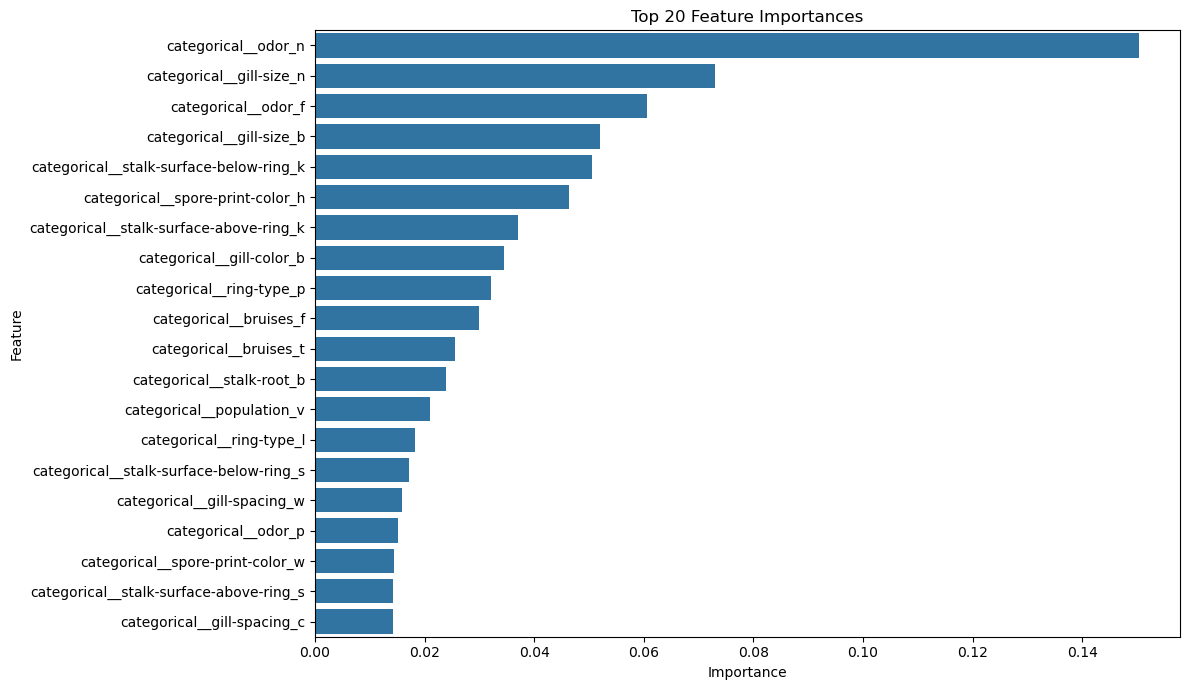

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Get the best estimator from GridSearchCV
best_classifier = grid_search.best_estimator_['classifier']
preprocessor = grid_search.best_estimator_['preprocessor']

# Get feature names after one-hot encoding
# The preprocessor creates a transformer that has 'get_feature_names_out'
# We need to correctly call it on the transformed data
encoded_feature_names = preprocessor.get_feature_names_out(X_train.columns)

# Get feature importances
if hasattr(best_classifier, 'feature_importances_'):
    importances = best_classifier.feature_importances_
    feature_importances = pd.DataFrame({'feature': encoded_feature_names, 'importance': importances})
    feature_importances = feature_importances.sort_values(by='importance', ascending=False)

    print("Top 10 Feature Importances:")
    print(feature_importances.head(10))

    # Plot feature importances
    plt.figure(figsize=(12, 7))
    sns.barplot(x='importance', y='feature', data=feature_importances.head(20))
    plt.title('Top 20 Feature Importances')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()
else:
    print("The best classifier does not have feature_importances_ attribute.")

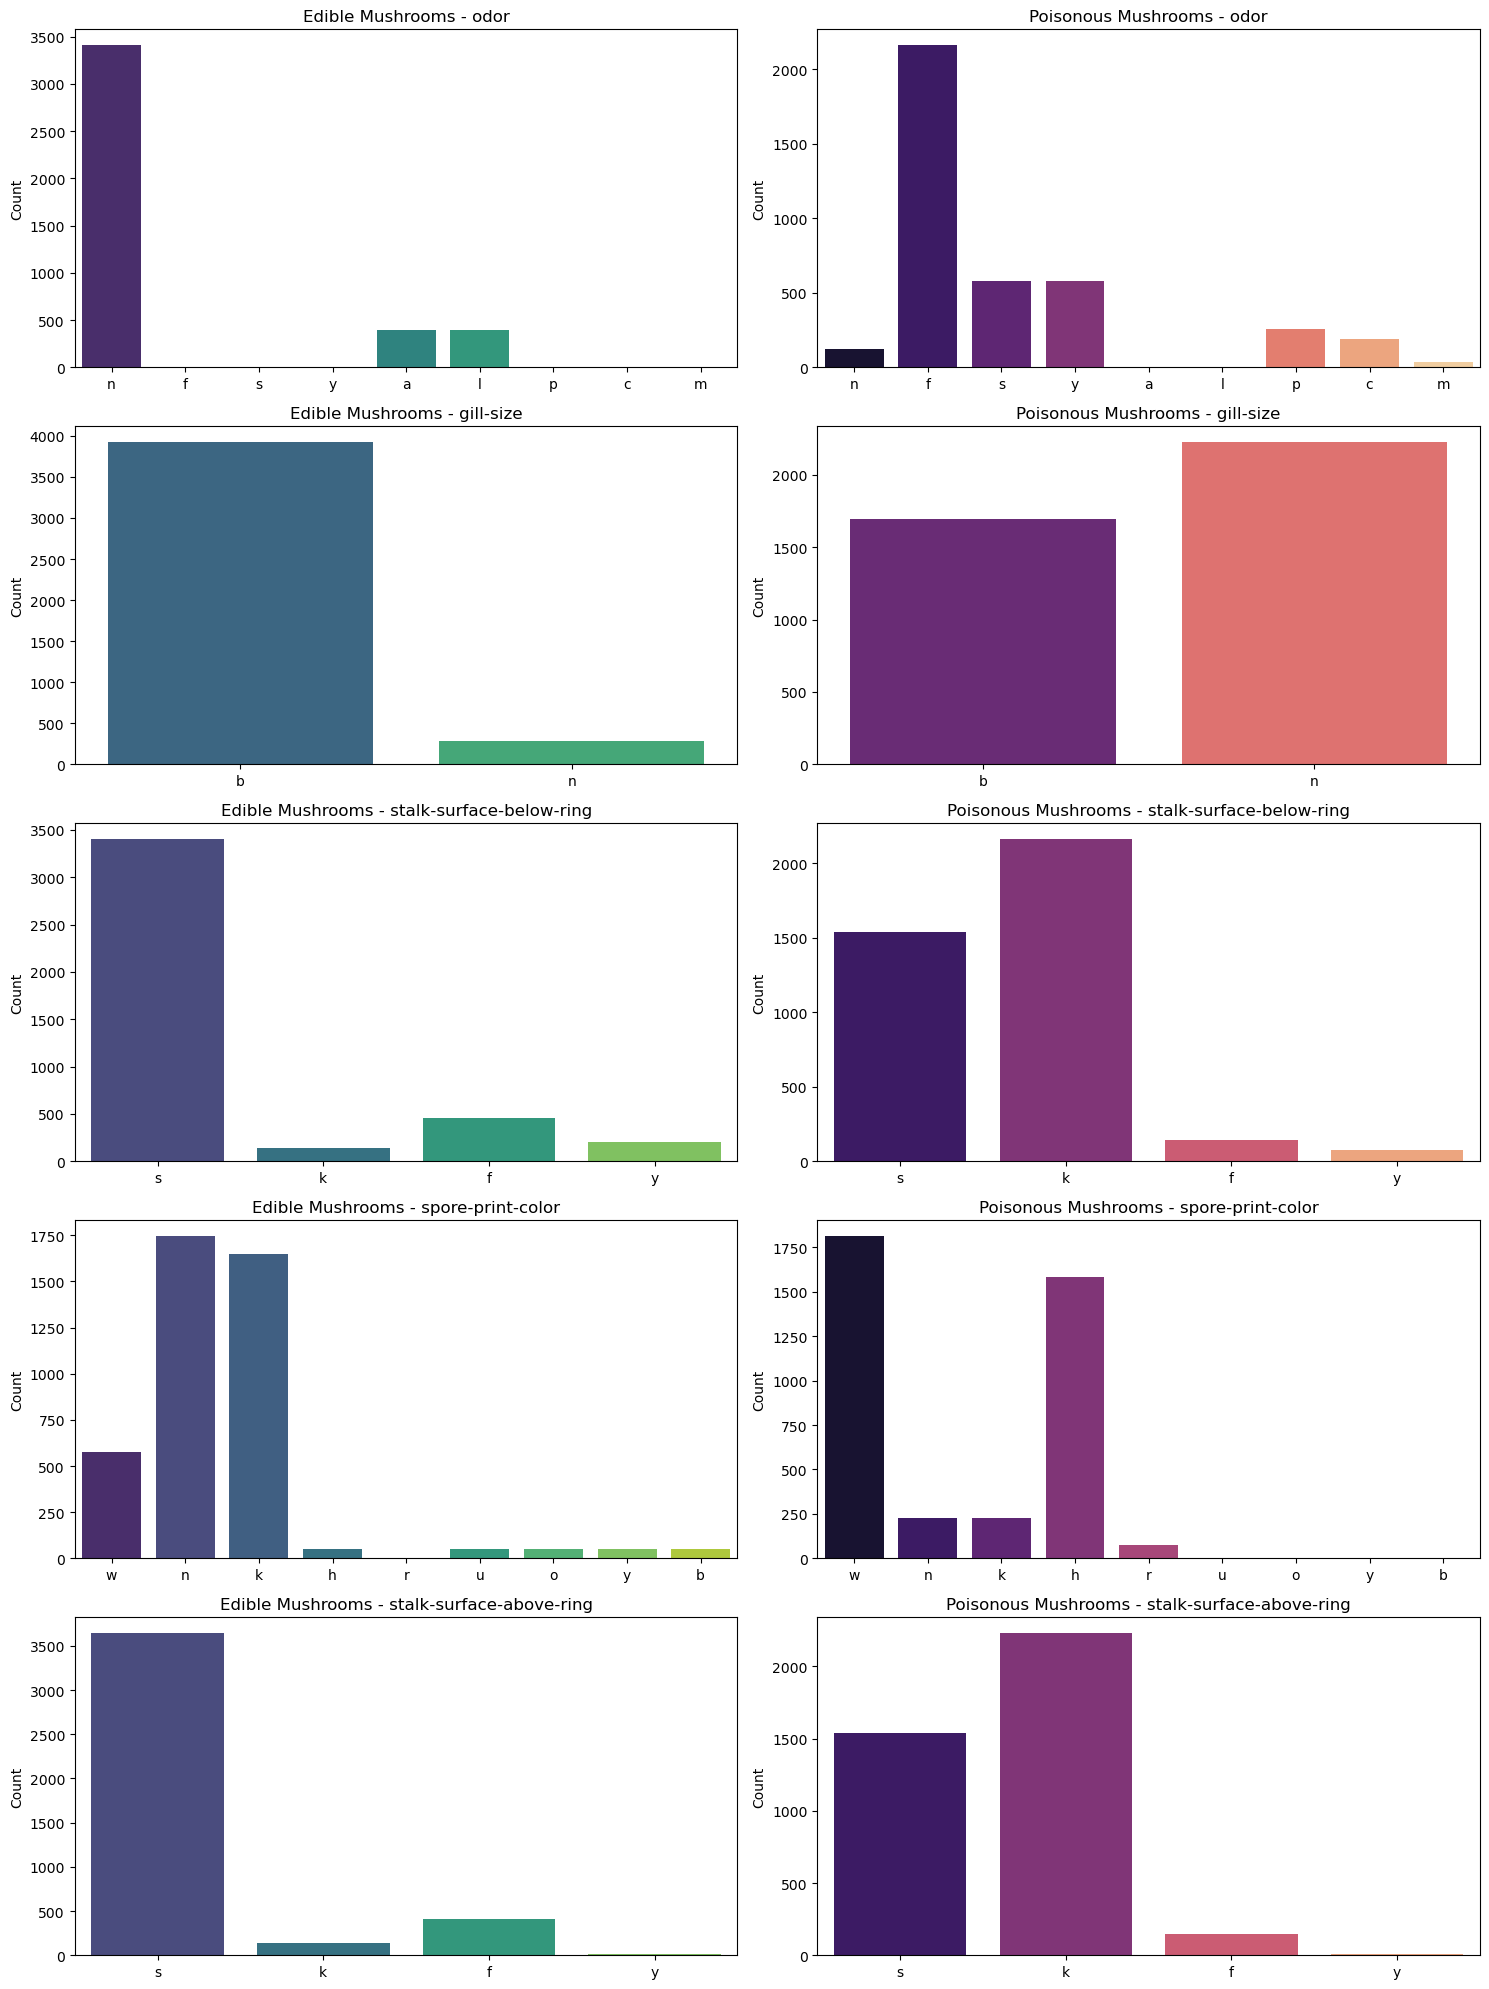

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

# Extract the original feature names from the feature_importances
# Assuming feature_importances is already available from the previous cell
feature_importances['original_feature'] = feature_importances['feature'].apply(lambda x: x.split('__')[1].rsplit('_', 1)[0] if '__' in x else x)
top_original_features = feature_importances['original_feature'].unique()[:5]

# Plot countplots for the top original features, separated by 'class'
plt.figure(figsize=(15, len(top_original_features) * 4))
for i, feature in enumerate(top_original_features):
    plt.subplot(len(top_original_features), 2, 2*i + 1) # Create subplot for 'edible'
    sns.countplot(data=mushroom[mushroom['class'] == 'e'], x=feature, order=mushroom[feature].value_counts().index, palette='viridis')
    plt.title(f'Edible Mushrooms - {feature}')
    plt.xlabel('')
    plt.ylabel('Count')

    plt.subplot(len(top_original_features), 2, 2*i + 2) # Create subplot for 'poisonous'
    sns.countplot(data=mushroom[mushroom['class'] == 'p'], x=feature, order=mushroom[feature].value_counts().index, palette='magma')
    plt.title(f'Poisonous Mushrooms - {feature}')
    plt.xlabel('')
    plt.ylabel('Count')

plt.tight_layout()
plt.show()


Let's visualize the relationship between `odor` and `gill-size`, broken down by the mushroom's `class`. This will help us understand if certain combinations of these features are more indicative of edibility or poisonousness.

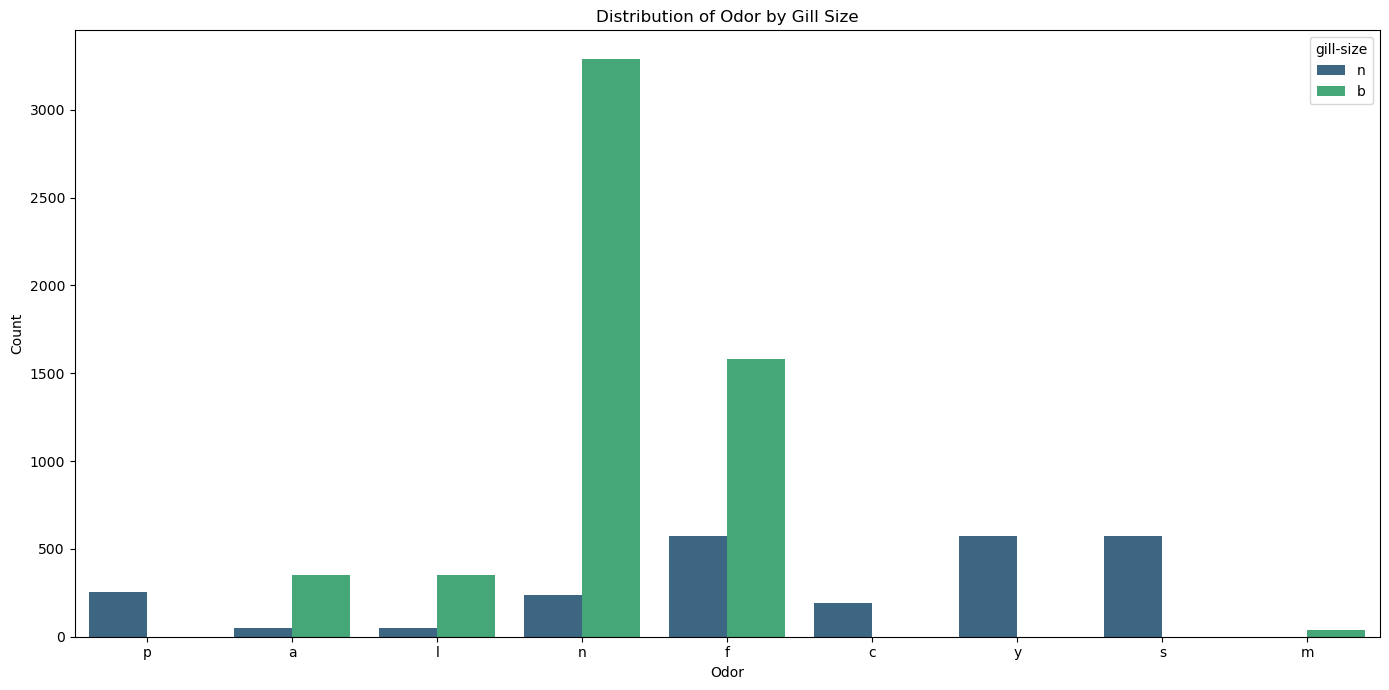

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 7))
sns.countplot(data=mushroom, x='odor', hue='gill-size', palette='viridis')
plt.title('Distribution of Odor by Gill Size')
plt.xlabel('Odor')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

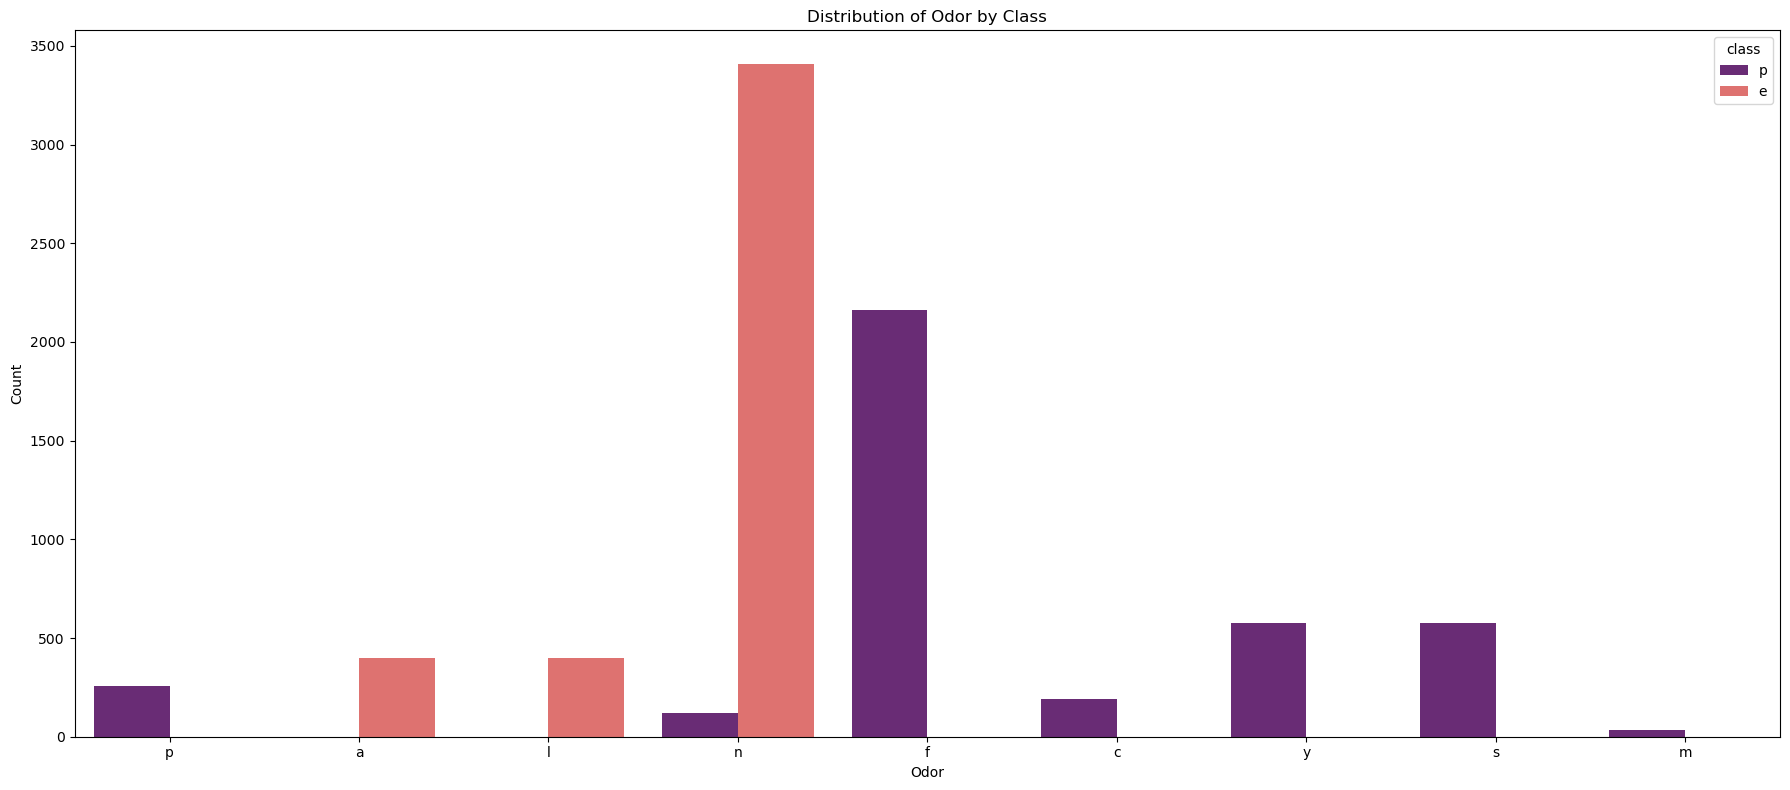

In [22]:
plt.figure(figsize=(18, 8))
sns.countplot(data=mushroom, x='odor', hue='class', palette='magma')
plt.title('Distribution of Odor by Class')
plt.xlabel('Odor')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

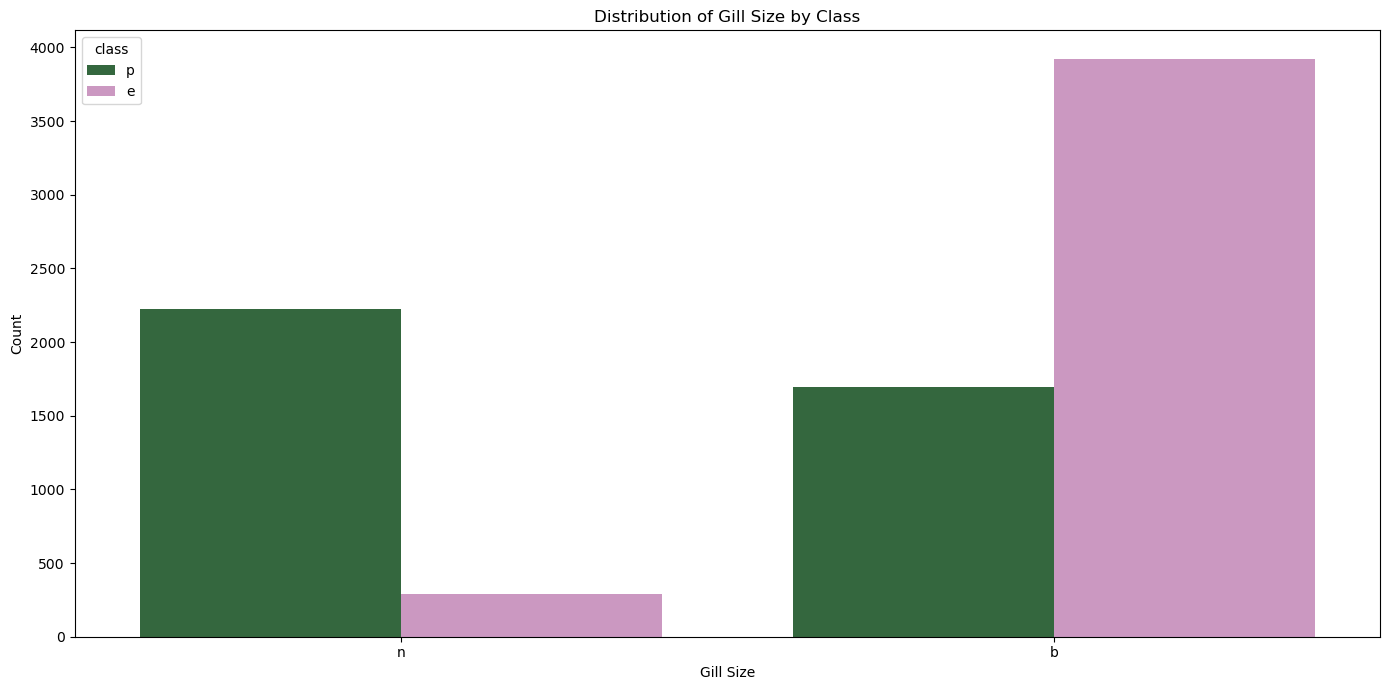

In [23]:
plt.figure(figsize=(14, 7))
sns.countplot(data=mushroom, x='gill-size', hue='class', palette='cubehelix')
plt.title('Distribution of Gill Size by Class')
plt.xlabel('Gill Size')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

['cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor', 'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color', 'stalk-shape', 'stalk-root', 'stalk-surface-above-ring', 'stalk-surface-below-ring', 'stalk-color-above-ring', 'stalk-color-below-ring', 'veil-type', 'veil-color', 'ring-number', 'ring-type', 'spore-print-color', 'population', 'habitat']


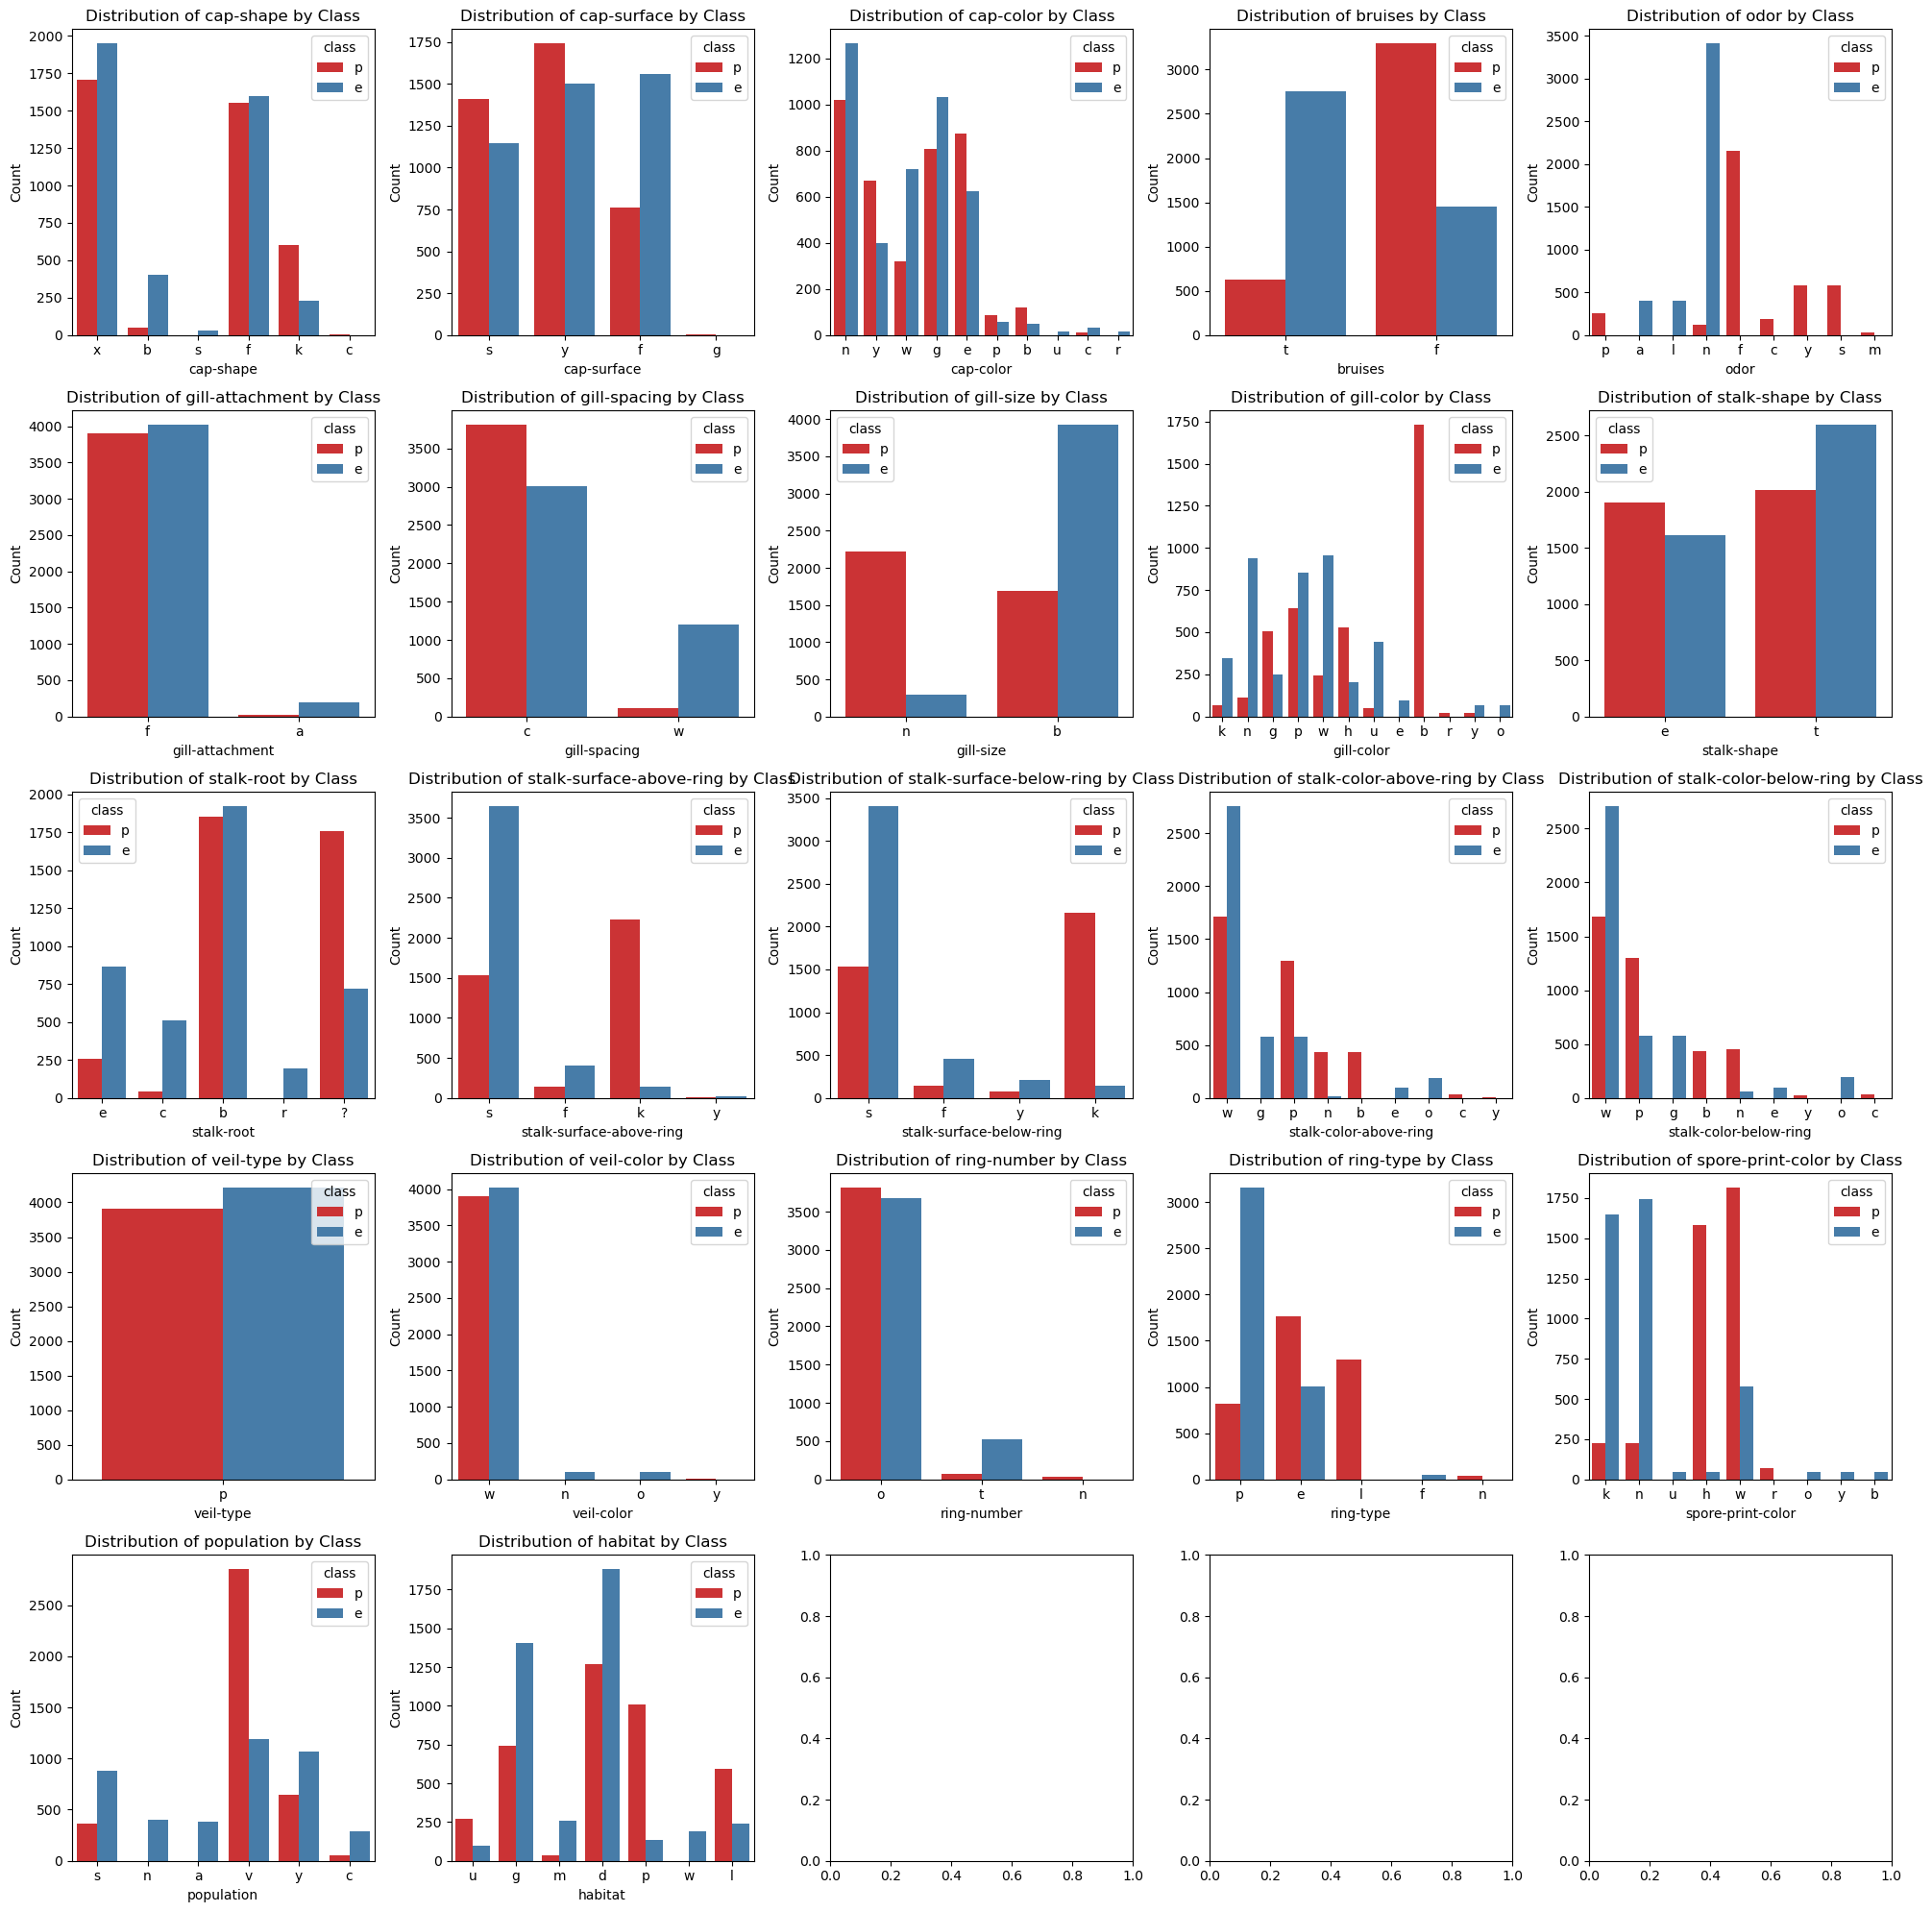

In [72]:
# Count plot for each category
fig,axes=plt.subplots(5,5,figsize=(20,20))
print(categorical_cols)
for i, col in enumerate(categorical_cols):
    sns.countplot(data=mushroom, x=col, hue='class', ax=axes[i//5, i%5], palette='Set1')
    axes[i//5, i%5].set_title(f'Distribution of {col} by Class')
    axes[i//5, i%5].set_xlabel(col)
    axes[i//5, i%5].set_ylabel('Count')
plt.tight_layout()
plt.show()

In [ ]:
# TODO: select only obvious ones for presentation